# Reading data

In [1]:
import pandas as pd

#Reading data from the 2019 ENEM test.
df = pd.read_csv('dados.csv', encoding = 'latin-1', sep = ';', usecols = ['TP_COR_RACA', 'TP_ESCOLA', 'NU_NOTA_REDACAO', 'NU_NOTA_MT',
                                                                                    'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_CN', 'Q001', 'Q006'])

#vendo como o df é
print(df)
df.columns

         TP_COR_RACA  TP_ESCOLA  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC  \
0                  3          1         NaN         NaN         NaN   
1                  1          1         NaN         NaN         NaN   
2                  3          1         NaN         NaN         NaN   
3                  1          1       483.8       503.6       537.3   
4                  1          1       513.6       575.5       570.7   
...              ...        ...         ...         ...         ...   
5095166            3          1         NaN         NaN         NaN   
5095167            3          1         NaN       578.9       555.5   
5095168            0          1         NaN         NaN         NaN   
5095169            0          1         NaN         NaN         NaN   
5095170            0          1         NaN         NaN         NaN   

         NU_NOTA_MT  NU_NOTA_REDACAO Q001 Q006  
0               NaN              NaN    B    A  
1               NaN              NaN    C    C  


Index(['TP_COR_RACA', 'TP_ESCOLA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001', 'Q006'],
      dtype='object')

# Data cleaning

In [2]:
# Renaming some columns
df.rename(columns = {'TP_ESCOLA' : 'Tipo de Escola', 'NU_NOTA_MT' : 'Nota Matematica',
                     'NU_NOTA_CH': 'Nota Humanas', 'NU_NOTA_LC' : 'Nota Linguagens',
                    'NU_NOTA_CN': 'Nota Natureza',
                    'Q001' : 'Escolaridade Pai', 'Q006' : 'Renda Familiar', 
                    'NU_NOTA_REDACAO' : 'Nota Redacao'}, inplace = True)

In [3]:
# creating a new column to keep the score mean
df['Media'] = (df['Nota Humanas'] + df['Nota Matematica'] + df['Nota Linguagens'] + df['Nota Natureza'] + df['Nota Redacao'])/5


In [4]:
# Removing invalid values for mean

df = df.loc[df['Media'] >= 0]

# removing the individual scores
df.drop(columns = [i for i in df.columns if 'Nota' in i], inplace = True)

In [5]:
# fixing index

df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)
df

,TP_COR_RACA,Tipo de Escola,Escolaridade Pai,Renda Familiar,Media
0,1,1,C,E,475.34
1,1,1,E,G,639.36
2,2,1,B,E,649.62
3,3,1,E,B,534.98
4,1,2,E,F,495.04
...,...,...,...,...,...
3701904,1,1,B,G,477.38
3701905,4,1,A,C,442.10
3701906,1,2,E,B,427.02
3701907,3,1,H,E,516.54


In [ ]:
# now lets modify the categorical parameters to make represent them with letters

df['Renda Familiar'].replace({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4,
            'E' : 5, 'F' : 6, 'G' : 7, 'H' : 8,
            'I' : 9, 'J' : 10, 'K' : 11, 'L' : 12,
            'M' : 13, 'N' : 14, 'O' : 15, 'P' : 16,
            'Q' : 17}, inplace = True)
df['Escolaridade Pai'].replace({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4,
            'E' : 5, 'F' : 6, 'G' : 7, 'H' : 8}, inplace = True)

# Building the model

## Classifier tree

In [7]:
# defining two groups: 
# 0: scores under 620
# 1: scores equal/above 620

df_classifier = df.copy()

def discretizar(n):
    if (n >= 620):
        return 1
    else: return 0


df_classifier['Media'] = df_classifier['Media'].apply(discretizar)

In [28]:
x = df_classifier[['Escolaridade Pai', 'Renda Familiar', 'Tipo de Escola']]
y = df_classifier['Media']

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#spliting data
x_train, x_test, y_train, y_test = train_test_split(x, y)

tree_classifier = DecisionTreeClassifier(max_depth = 6)

In [29]:
#training model
tree_classifier.fit(x_train, y_train)

print("Results with training set: ", tree_classifier.score(x_train, y_train))
print("Results with testing set ", tree_classifier.score(x_test, y_test))

Results with training set:  0.8731911580010452
Results with testing set  0.8736209828866812


- The results are very impressive and show the model's capability in predicting wheather the student is going to get a good score (above 620) or not, based on their financial profile, parents education and school.

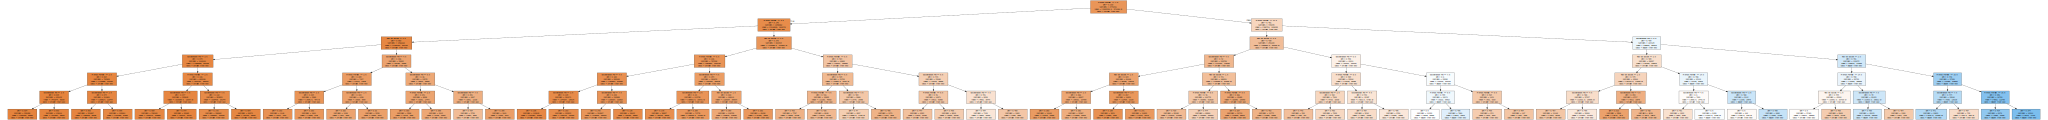

In [10]:
# visualising the tree
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree_classifier, out_file = 'tree.dot', class_names = ['smaller than 650', 'bigger than 650'], filled = True, feature_names = x.columns)
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Regressive tree

In [11]:
#spliting data
df_regressor = df.copy()
y = df_regressor['Media']
x = df_regressor[['Escolaridade Pai', 'Renda Familiar', 'Tipo de Escola']]

x_train, x_test, y_train, y_test = train_test_split(x, y)

from sklearn.tree import DecisionTreeRegressor

#building model
tree_regressor = DecisionTreeRegressor(max_depth = 4)

In [12]:
#training model
tree_regressor.fit(x_train, y_train)

#testing
from sklearn.metrics import mean_absolute_error

predict = tree_regressor.predict(x_test)
#calculating the mean error between the actual scores and the predicted scores
error = mean_absolute_error(predict, y_test)

print(f"Mean absolute error {error} points")

Mean absolute error 57.02684766436403 points


- We got a model that can predict a ENEM score with a mean absolute error of 57 points

- That's a reasonable precision, given the wide space of possible values, and possible us to give a fair shot about the student's grade.

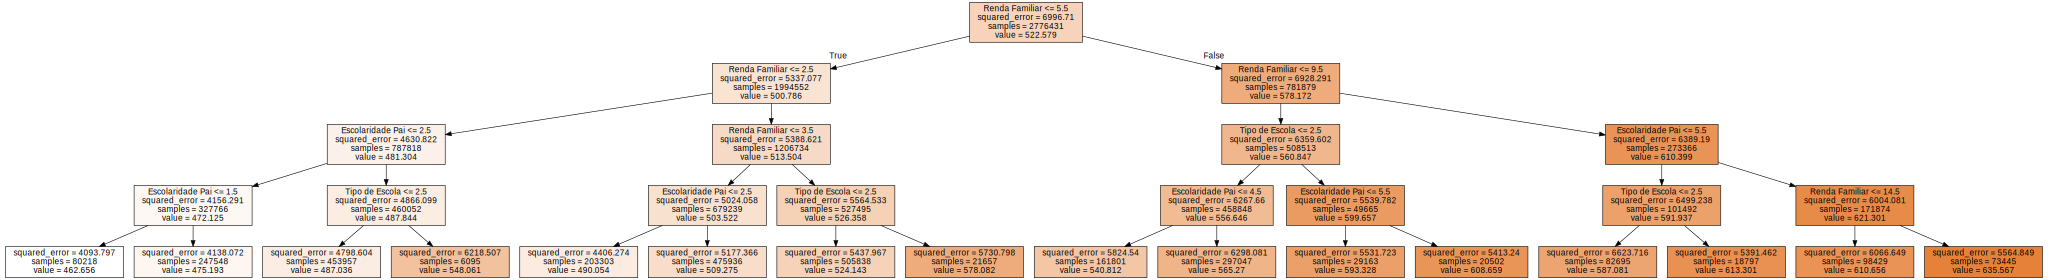

In [13]:
#visualising the tree
export_graphviz(tree_regressor, out_file = 'tree.dot', filled = True, feature_names = x.columns)
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# Testing against other data

- now I'm going to test my models against the data from other ENEM years.
- the models were trained based on the data available on ENEM 2019. Now I'll utilise ENEM 2021 to verify the capability to predict scores on other years.

In [ ]:
enem2021 = pd.read_csv('dados2021.csv', sep = ';', encoding = 'latin-1', usecols = ['TP_COR_RACA', 'TP_ESCOLA', 'NU_NOTA_REDACAO', 'NU_NOTA_MT',
                                                                                    'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_CN', 'Q001', 'Q006'])
enem2021.rename(columns = {'TP_ESCOLA' : 'Tipo de Escola', 'NU_NOTA_MT' : 'Nota Matematica',
                     'NU_NOTA_CH': 'Nota Humanas', 'NU_NOTA_LC' : 'Nota Linguagens',
                    'NU_NOTA_CN': 'Nota Natureza',
                    'Q001' : 'Escolaridade Pai', 'Q006' : 'Renda Familiar', 
                    'NU_NOTA_REDACAO' : 'Nota Redacao'}, inplace = True)

enem2021['Renda Familiar'].replace({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4,
            'E' : 5, 'F' : 6, 'G' : 7, 'H' : 8,
            'I' : 9, 'J' : 10, 'K' : 11, 'L' : 12,
            'M' : 13, 'N' : 14, 'O' : 15, 'P' : 16,
            'Q' : 17}, inplace = True)
enem2021['Escolaridade Pai'].replace({'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4,
            'E' : 5, 'F' : 6, 'G' : 7, 'H' : 8}, inplace = True)

In [15]:
enem2021['Media'] = (enem2021['Nota Humanas'] + enem2021['Nota Matematica'] + enem2021['Nota Linguagens'] + enem2021['Nota Natureza'] + enem2021['Nota Redacao'])/5

# Removing invalid values for mean
enem2021 = enem2021.loc[enem2021['Media'] >= 0]
# removing the individual scores
enem2021.drop(columns = [i for i in enem2021.columns if 'Nota' in i], inplace = True)

In [16]:
enem2021.reset_index(inplace = True)
enem2021.drop(columns = 'index', inplace = True)

### Testing the classifier model

In [33]:
x_test = enem2021[['Escolaridade Pai', 'Renda Familiar', 'Tipo de Escola']]
y_test = enem2021['Media'].copy()

y_test = y_test.apply(discretizar)

In [34]:
print("Classifier score on the 2021 ENEM data: ", tree_classifier.score(x_test, y_test))

Classifier score on the 2021 ENEM data:  0.8261378924242675


### Testing the regressor model

In [35]:
error = mean_absolute_error(tree_regressor.predict(x_test), enem2021['Media'])
print("Mean absolute error of regressor model (points): ", error)

Mean absolute error of regressor model (points):  62.130112672687275


# Results

- The model performed very well against the test set of students of the same year.
    - The classifier model obtained 87% of efficience when tested against the 2019 students.
      
    - The Regressor moedl obtained a 57 points avarage error when tested against the 2019 stundets.
 
- When we tested both models against other students, of a different year with totally different ENEM questions, we got very good results:
    - The classifier model obtained 82% of efficience when tested againts the 2021 students.
      
    - The regressor model obtained a 62 points avarage error when tested against the 2021 students.
 
It was expected that the models would perform better in the same year that they were trained. However, the high performance in another year shows clearly that the models can predict the grade very well and are not overfitted to the data of a specific year.


-------------------------------------
- O modelo perfomou muito bem no conjunto de treinamento do mesmo ano em que ele foi treinado (2019):
    - O modelo de classificação conseguiu prever se o estudante tiraria mais ou menos que 620 pontos em 87% dos casos.
    - O modelo de regressão conseguiu prever a nota de um estudante com um erro médio de 57 pontos.
 
- Quando testei os modelos com dados de outro ano (2021), os resultados se mantiveram firmes e consistentes:
    - O modelo de classificação acertou em 82% dos casos.
    - O modelo de regressão teve um erro médio de 62 pontos.
 
Já era esperado que os modelos iriam se sair bem quando avaliados no mesmo ano que o treinamento ocorreu (vale lembrar que o treinamento ocorreu com estudantes diferentes dos usados na avaliação de 2019). Mas o fato de a performance se manter boa quando testamos os modelos em outro ano mostra claramente que as árvores não sofreram overfit com os dados usados em 2019, mas conseguem se comportar bem em conjuntos de dados novos.

Além disso, a escolha de 620 para a nota de referência no modelo de classificação é relevante pois esta é uma nota considerada boa no vestibular (muitos cursos de graduação tem notas de corte próximas dessa) e vê-se que o fato do estudante tirar ou não essa nota é fortemente influenciado por fatores de renda, escola e escolaridade paterna, como é visto na árvore de decisão.

#### Data references

In [ ]:
you can check the data I used on:
https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem